## Train CFM

In [1]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs

configs = Configs(# data:
                  DATA = 'LHCOlympics',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 
                  cuts_sideband_low = {'mjj': [1000, 3000]},  
                  cuts_sideband_high = {'mjj': [4000, 13000]}, 
                  dim_input = 5,
                  num_dijets = 90000,  
                  # training params:   
                  DEVICE = 'cpu',
                  EPOCHS = 3000,
                  batch_size = 256,
                  print_epochs = 20,
                  early_stopping = 200,
                  min_epochs = 2000,
                  data_split_fracs = [0.8, 0.2, 0.0],
                  lr = 1e-3,
                  optimizer = 'Adam',
                  fix_seed = 12345,
                  # model params:
                  MODEL = 'MLP',
                  dim_hidden = 512,
                  num_layers = 4,
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 500
                )

configs.set_workdir(path='../../results', save_config=True)

#=====================================================================================
INFO: created directory: ../../results/LHCOlympics.CondFlowMatch.MLP.2023.11.06_22h05
#=====================================================================================
+---------------------+--------------------------------------------------------------------------+
| Parameters          | Values                                                                   |
+---------------------+--------------------------------------------------------------------------+
| DATA                | LHCOlympics                                                              |
| dataset             | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features            | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input           | 5                                                                        |
| preprocess          | ['normalize', 'logit_tr

In [2]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset, LHCOlympicsDataset 
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco = LHCOlympicsHighLevelDataset(configs)
cfm = DynGenModelTrainer(dynamics = SimplifiedCondFlowMatching(configs),
                         model = MLP(configs), 
                         dataloader = LHCOlympicsDataLoader(lhco, configs), 
                         configs = configs)

#...train model:

cfm.train()

/Users/dario/Dropbox/PROJECTS/ML/DynGenModels/src/DynGenModels/datamodules/lhco/datasets.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  dijets = torch.Tensor(f['jet features'])
/Users/dario/Dropbox/PROJECTS/ML/DynGenModels/src/DynGenModels/datamodules/lhco/dataprocess.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(self.features[:self.num_dijets])
number of training parameters: 794117
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 72000, validation size: 18000, testing sizes: 0


epochs:   0%|          | 0/3000 [00:00<?, ?it/s]

	Epoch: 1, train loss: 1.5633445631527734, valid loss: 1.5821128613512283  (min valid loss: 1.5821128613512283)
	Epoch: 21, train loss: 1.5177740919674545, valid loss: 1.6420908158933616  (min valid loss: 1.5518056137461056)
	Epoch: 41, train loss: 1.5081733630058616, valid loss: 1.5772828451344665  (min valid loss: 1.5506719082174165)
	Epoch: 61, train loss: 1.5062531524516183, valid loss: 1.559508412656649  (min valid loss: 1.5506719082174165)
	Epoch: 81, train loss: 1.4937131776877335, valid loss: 1.5861780643463135  (min valid loss: 1.5446435397779443)
	Epoch: 101, train loss: 1.4916576878398866, valid loss: 1.6107092474547915  (min valid loss: 1.5446435397779443)
	Epoch: 121, train loss: 1.480326166812409, valid loss: 1.6104008714917684  (min valid loss: 1.5446435397779443)
	Epoch: 141, train loss: 1.4684778697101777, valid loss: 1.872732968397543  (min valid loss: 1.5446435397779443)
	Epoch: 161, train loss: 1.468612844639637, valid loss: 1.6327472941976198  (min valid loss: 1.54

In [3]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PostProcessLHCOlympicsHighLevelData

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=lhco.source_preprocess,
                             configs=configs, 
                             postprocessor= PostProcessLHCOlympicsHighLevelData,
                             best_epoch_model=True)


INFO: neural ODE solver with midpoint method and steps=500


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


/Users/dario/anaconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


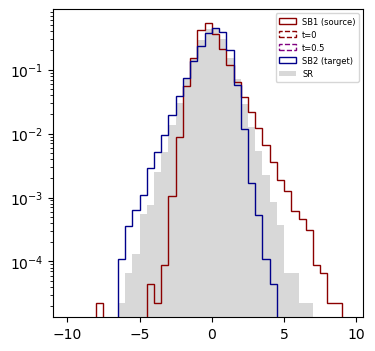

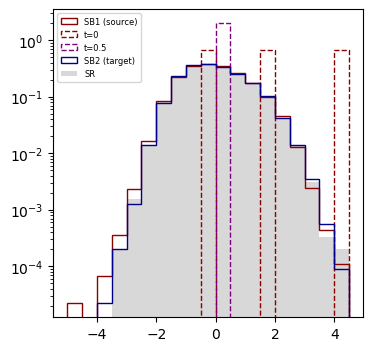

In [4]:
import matplotlib.pyplot as plt

log = True
bins = np.arange(-10,10,0.5)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.hist(lhco.source_preprocess[...,0], bins=bins, histtype='step', color='darkred', label='SB1 (source)', log=log, density=True)
plt.hist(pipeline.source[...,0], bins=bins, histtype='step', color='darkred', ls='--',label='t=0', log=log, density=True)
plt.hist(pipeline.midway[...,0], bins=bins, histtype='step', color='purple', ls='--',label='t=0.5', log=log, density=True)
plt.hist(lhco.target_preprocess[...,0], bins=bins, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=True)
plt.hist(lhco.background_preprocess[...,0],bins=bins, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=True)
plt.legend(fontsize=6)

log = True
bins = np.arange(-5,5,0.5)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.hist(lhco.source_preprocess[...,1], bins=bins, histtype='step', color='darkred', label='SB1 (source)', log=log, density=True)
plt.hist(pipeline.source[...,1], bins=bins, histtype='step', color='darkred', ls='--',label='t=0', log=log, density=True)
plt.hist(pipeline.midway[...,1], bins=bins, histtype='step', color='purple', ls='--',label='t=0.5', log=log, density=True)
plt.hist(lhco.target_preprocess[...,1], bins=bins, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=True)
plt.hist(lhco.background_preprocess[...,1],bins=bins, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=True)
plt.legend(fontsize=6)


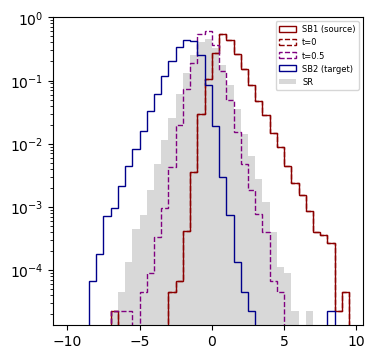

In [53]:
import matplotlib.pyplot as plt

log = True
bins = np.arange(-10,10,0.5)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.hist(lhco.source_preprocess[...,0], bins=bins, histtype='step', color='darkred', label='SB1 (source)', log=log, density=True)
plt.hist(pipeline.source[...,0], bins=bins, histtype='step', color='darkred', ls='--',label='t=0', log=log, density=True)
plt.hist(pipeline.midway[...,0], bins=bins, histtype='step', color='purple', ls='--',label='t=0.5', log=log, density=True)
plt.hist(lhco.target_preprocess[...,0], bins=bins, histtype='step', color='darkblue',  label='SB2 (target)', log=log, density=True)
plt.hist(lhco.background_preprocess[...,0],bins=bins, histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=log, density=True)
plt.legend(fontsize=6)



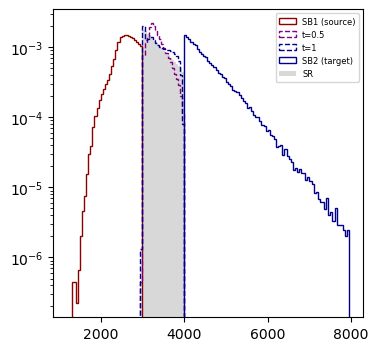

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.hist(lhco.source[...,0], bins=np.arange(1200,8000,50), histtype='step', color='darkred', label='SB1 (source)', log=True, density=True)
plt.hist(pipeline.midway[...,0], bins=np.arange(1200,8000,50), histtype='step', color='purple', ls='--',label='t=0.5', log=True, density=True)
plt.hist(pipeline.target[...,0], bins=np.arange(1200,8000,50), histtype='step', color='darkblue', ls='--',label='t=1', log=True, density=True)
plt.hist(lhco.target[...,0], bins=np.arange(1200,8000,50), histtype='step', color='darkblue',  label='SB2 (target)', log=True, density=True)
plt.hist(lhco.background[...,0], bins=np.arange(1200,8000,50), histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=True, density=True)
plt.legend(fontsize=6)
plt.show()

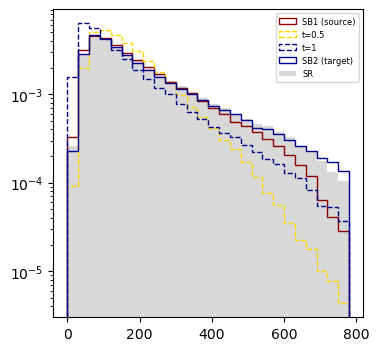

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
plt.hist(lhco.source[...,1], bins=np.arange(0,800,30), histtype='step', color='darkred', label='SB1 (source)', log=True, density=True)
plt.hist(pipeline.midway[...,1], bins=np.arange(0,800,30), histtype='step', color='gold', ls='--',label='t=0.5', log=True, density=True)
plt.hist(pipeline.target[...,1], bins=np.arange(0,800,30), histtype='step', color='darkblue', ls='--',label='t=1', log=True, density=True)
plt.hist(lhco.target[...,1], bins=np.arange(0,800,30), histtype='step', color='darkblue',  label='SB2 (target)', log=True, density=True)
plt.hist(lhco.background[...,1], bins=np.arange(0,800,30), histtype='stepfilled', color='gray', alpha=0.3, label='SR', log=True, density=True)
plt.legend(fontsize=6)
plt.show()

# Sample from Pretrained CFM

Load a previsoiusly trained model that was stored somewhere in a directory. The directory must contain the follwing files:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.


### 1. Load pre-trained model
promising runs:

 - LHCOlympics.CondFlowMatch.MLP.2023.11.01_22h09
 

In [ ]:
#...provide the directory of the trained model and load the configuration file in it:

from DynGenModels.configs.lhco_configs import LHCOlympics_MLP_CondFlowMatch as Configs

model_workdir = '../../results/LHCOlympics.CondFlowMatch.MLP.2023.11.01_22h09'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:3'   # select device
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

from DynGenModels.datamodules.lhco.datasets import LHCOlympicsDataset 
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import SimplifiedCondFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco = LHCOlympicsDataset(configs)
pretrained_cfm = DynGenModelTrainer(dynamics = SimplifiedCondFlowMatching(configs),
                                    model = MLP(configs), 
                                    dataloader = LHCOlympicsDataLoader(lhco, configs), 
                                    configs = configs)

#...load the pre-trained model:

pretrained_cfm.load(model='best')

### 2. sample from loaded models

In [6]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 

pipeline = FlowMatchPipeline(trained_model=pretrained_cfm, 
                             source_input=lhco.source,
                             configs=configs, 
                             solver = 'dopri5',
                             best_epoch_model=True)

NameError: name 'pretrained_cfm' is not defined

### Plot results:

In [ ]:
import numpy as np
from utils import plot_jet_features, plot_dijet_mass

STEP = configs.num_sampling_steps/2
D_STEP = configs.num_sampling_steps/4

plot_jet_features(lhco, pipeline.trajectories, 'p_t', time_step=STEP, d_step=D_STEP, xlim=(1000, 3000, 40))
plot_jet_features(lhco, pipeline.trajectories, '\eta', time_step=STEP, d_step=D_STEP, xlim=(-3, 3, 0.05))
plot_jet_features(lhco, pipeline.trajectories, '\phi', time_step=STEP, d_step=D_STEP, xlim=(-1, 12, 0.1))
plot_jet_features(lhco, pipeline.trajectories, 'm', time_step=STEP, d_step=D_STEP, xlim=(0, 1000, 10))
plot_dijet_mass(lhco, pipeline.trajectories, bins=np.arange(2000, 10000, 20), time_step=STEP, d_step=D_STEP, figsize=(4,4))